In [1]:
from circuits_benchmark.utils.get_cases import get_cases
from circuits_benchmark.commands.build_main_parser import build_main_parser
from circuits_benchmark.utils.iit.correspondence import TracrCorrespondence
from circuits_benchmark.utils.iit._acdc_utils import get_gt_circuit
from circuits_benchmark.transformers.acdc_circuit_builder import get_full_acdc_circuit, replace_inputs_and_qkv_nodes_with_outputs, replace_inputs_and_qkv_edges_with_outputs

task = 7

args, _ = build_main_parser().parse_known_args(
            [
                "compile",
                f"-i={task}",
                "-f",
            ]
        )
case = get_cases(args)[0]
assert case.get_index() == str(task), f"Expected case {task}, got {case.get_index()}"

tracr_output = case.build_tracr_model()
# tracr_output_2 = case.build_tracr_model()

tracr_output.graph.nodes # , tracr_output_2.graph.nodes
hl_ll_corr = TracrCorrespondence.from_output(case, tracr_output)

In [2]:
hl_ll_corr

{TracrHLNode(name: blocks.0.mlp.hook_post,
  label: hist_1_selector_width_attn_output,
  classes: 0,
  index: [:]
 ): {LLNode(name='blocks.0.mlp.hook_post', index=[:], subspace=None)},
 TracrHLNode(name: blocks.0.mlp.hook_post,
  label: hist_1,
  classes: 0,
  index: [:]
 ): {LLNode(name='blocks.0.mlp.hook_post', index=[:], subspace=None)}}

In [3]:
from circuits_benchmark.transformers.circuit_node import CircuitNode
for k, v in hl_ll_corr.items():
    if k == CircuitNode('blocks.1.attn.hook_result', 2):
        print(k, v)
        break

In [4]:
from circuits_benchmark.utils.iit._acdc_utils import *
from circuits_benchmark.utils.iit.correspondence import TracrHLNode
from typing import List, Tuple
    
def promote_node(node: CircuitNode):
    node_prefix = ".".join(node.name.split(".")[:-1])
    node_suffix = node.name.split(".")[-1]
    if node_suffix in ["hook_k_input", "hook_q_input", "hook_v_input"]:
        node = CircuitNode(f"{node_prefix}.attn.hook_result", node.index)
    elif node_suffix in ["hook_k", "hook_q", "hook_v"]:
        node = CircuitNode(f"{node_prefix}.hook_result", node.index)
    elif node_suffix == "mlp_in":
        node = CircuitNode(f"{node_prefix}.mlp.hook_post", node.index)
    
    return node

def promote_and_check_with_hl(node: CircuitNode, hl_ll_corr: correspondence.TracrCorrespondence) -> List[CircuitNode]:
    promoted_node = promote_node(node)
    for k, v in hl_ll_corr.items():
        if k == promoted_node:
            return v
    return None

def find_edge_in_circuit(tracr_circuit: Circuit, 
                         edge: Tuple[str, str],
                         hl_ll_corr: correspondence.TracrCorrespondence,
                         n_heads: int
                         ) -> bool:
    '''
    A whacky method to find the corresponding edge in the 'low-level' circuit, given tracr edges and a correspondence between them.
    '''
    for e in tracr_circuit.edges:
        # By default, the edge is the same as in tracr. 
        # This is useful when the hl_ll_corr maps only a subset of the tracr circuit. 
        # (I don't know why we are allowing this, but we need to do this for now.)
        new_ll_from_nodes = [e[0]] 
        new_ll_to_nodes = [e[1]]
        
        # make corresponding ll edges using hl_ll_corr
        v = promote_and_check_with_hl(e[0], hl_ll_corr) 
        # I need to promote and check because IIT is only defined for nodewise maps
        # So the corr only has hook_result/hook_mlp_out
        
        if v is not None:
            new_ll_from_nodes = []
            for node in v:
                new_ll_from_nodes.extend(get_circuit_nodes_from_ll_node(node, n_heads))

        v = promote_and_check_with_hl(e[1], hl_ll_corr)
        if v is not None:
            new_ll_to_nodes = []
            for node in v:
                new_ll_to_nodes.extend(get_circuit_nodes_from_ll_node(node, n_heads))

        new_edges = [(f, t) for f in new_ll_from_nodes for t in new_ll_to_nodes]
        edge = (promote_node(edge[0]), promote_node(edge[1])) # promote edge to match the nodes in the new_edges
        if edge in new_edges:
            return True
    return False

def get_gt_circuit(
    hl_ll_corr: correspondence.TracrCorrespondence,
    full_circuit: Circuit,
    n_heads: int,
    case: BenchmarkCase,
) -> Circuit:
    circuit = full_circuit.copy()
    corr_vals = hl_ll_corr.values()
    all_nodes = set(full_circuit.nodes)

    # get circuit nodes from ll nodes
    all_circuit_nodes = set()
    for nodes in corr_vals:
        for ll_node in nodes:
            circuit_nodes = get_circuit_nodes_from_ll_node(ll_node, n_heads)
            all_circuit_nodes.update(circuit_nodes)

    # get additional nodes needed
    additional_nodes_needed = set()
    nodes_to_check = ["resid", "embed", "unembed"]
    for node in all_nodes:
        # check if node.name contains the substrings in nodes_to_check
        if any([substr in node.name for substr in nodes_to_check]):
            additional_nodes_needed.add(node)
    nodes_needed = all_circuit_nodes.union(additional_nodes_needed)

    # remove nodes not needed
    nodes_to_remove = all_nodes - nodes_needed
    for node in nodes_to_remove:
        circuit.remove_node(node)
    
    # remove edges that are not a part of the tracr ground truth
    _, tracr_ll_circuit, _ = case.get_tracr_circuit(granularity="acdc_hooks")
    edges_to_remove = set()

    for edge in circuit.edges:
        if not find_edge_in_circuit(tracr_ll_circuit, edge, hl_ll_corr, n_heads):
            edges_to_remove.add(edge)
    
    for edge in edges_to_remove:
        # print(f"Removing edge {edge}")
        circuit.remove_edge(edge[0], edge[1])
    
    return circuit

In [5]:
import networkx as nx
import matplotlib.pyplot as plt
def plot_graph(g, prog="dot"):
    plt.figure(figsize=(35, 15))
    nx.draw(g, with_labels=True, pos=nx.nx_agraph.graphviz_layout(g, prog=prog), font_size=18, node_size=1500, font_color="red", font_weight="bold", node_color="skyblue", edge_color="black", width=1, arrowsize=20)

In [6]:
tracr_circuit = case.get_tracr_circuit(granularity="acdc_hooks")
cfg_dict = {
        "n_layers": 2,
        "n_heads": 4,
        "d_head": 4,
        "d_model": 8,
        "d_mlp": 16,
        "seed": 0,
        "n_ctx": case.get_max_seq_len(),
        "d_vocab": len(case.get_vocab()),
        "act_fn": "gelu",
}
from transformer_lens import HookedTransformer
from circuits_benchmark.transformers.acdc_circuit_builder import build_acdc_circuit
from acdc.TLACDCCorrespondence import TLACDCCorrespondence
ll_model = HookedTransformer(cfg_dict)


full_corr = TLACDCCorrespondence.setup_from_model(
            ll_model, use_pos_embed=True
        )
full_circuit = build_acdc_circuit(corr=full_corr)

iit_circuit = get_gt_circuit(hl_ll_corr=hl_ll_corr, full_circuit=full_circuit, n_heads=cfg_dict["n_heads"], case=case)

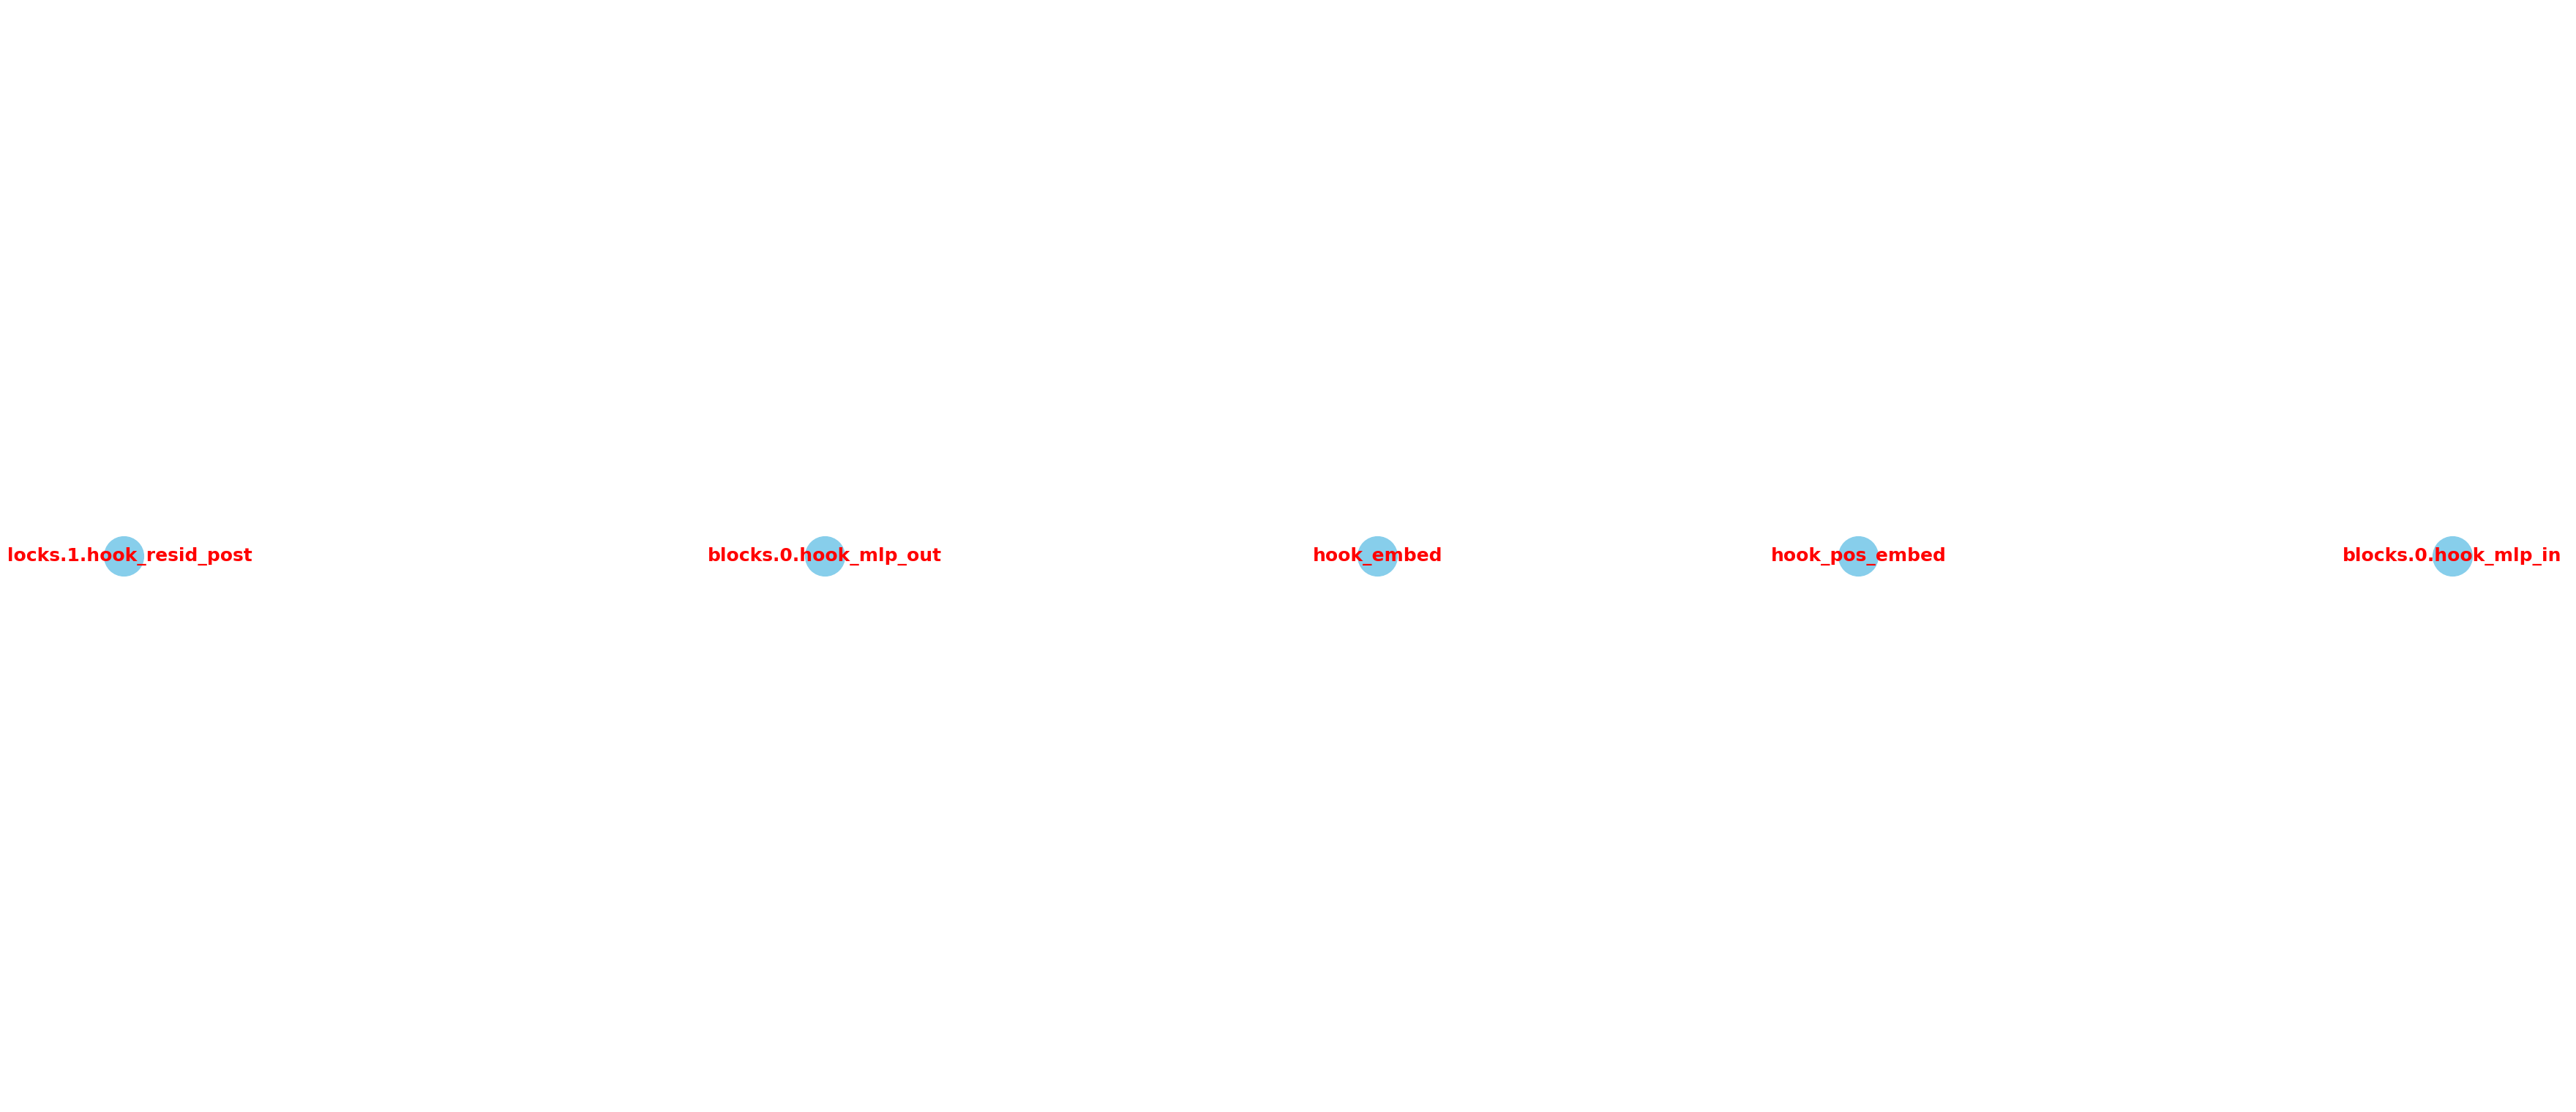

In [7]:
plot_graph(iit_circuit, "dot")

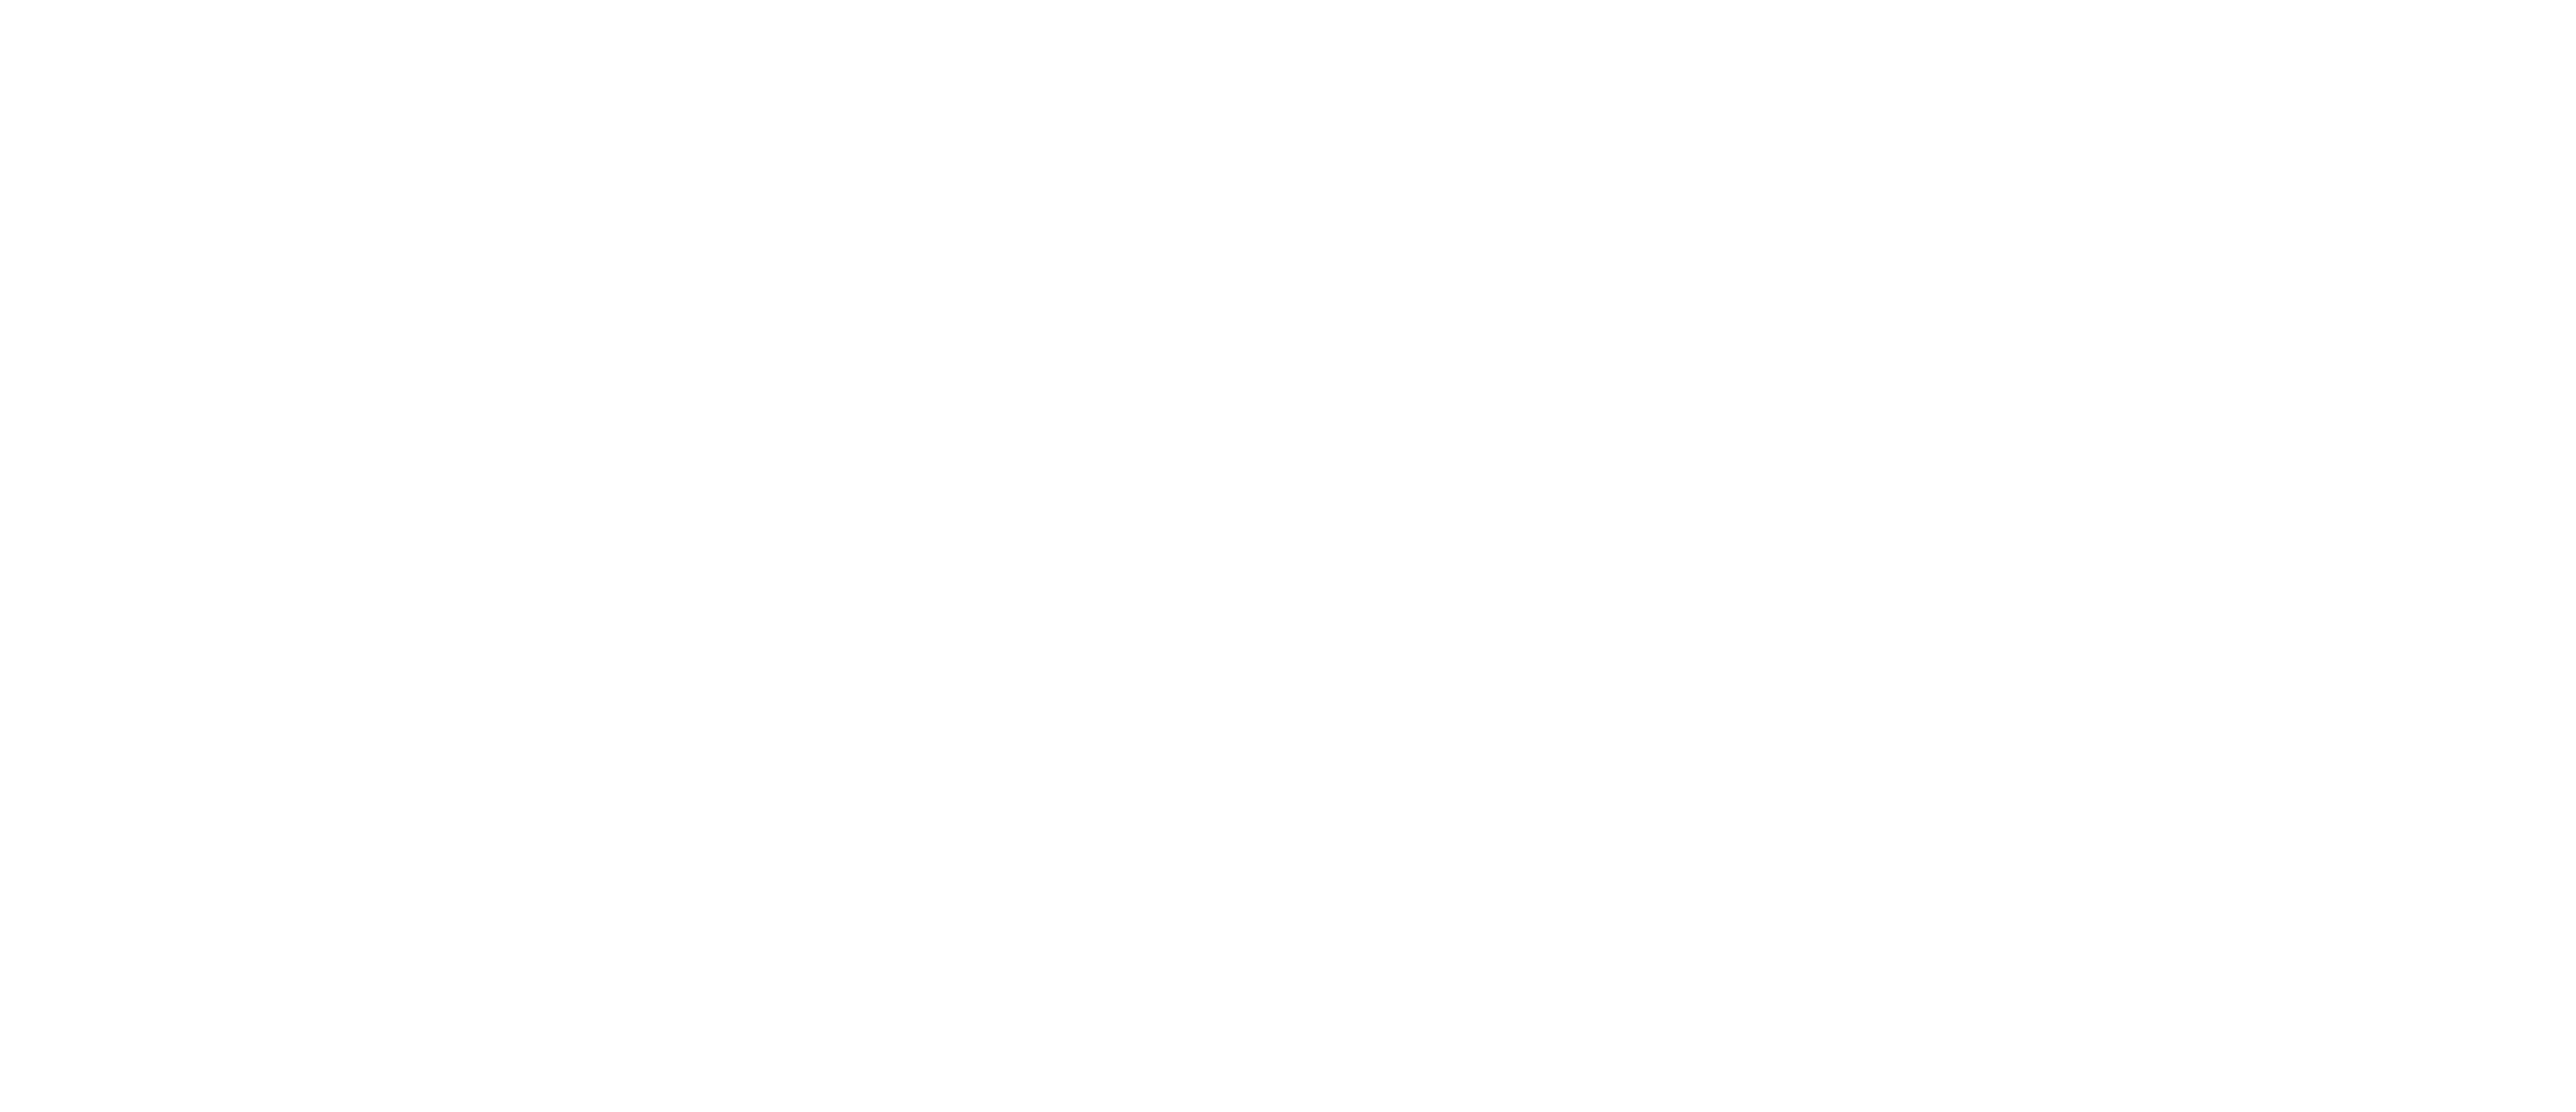

In [8]:
from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from circuits_benchmark.transformers.circuit import Circuit
from circuits_benchmark.transformers.circuit_node import CircuitNode
from acdc.TLACDCEdge import EdgeType

def replace_inputs_and_qkv_edges_with_outputs(circuit: Circuit) -> Circuit:
    new_circuit = Circuit()
    prefix = lambda node_name: ".".join(node_name.split(".")[:-1])
    suffix = lambda node_name: node_name.split(".")[-1]

    for from_node, to_node in circuit.edges:
        from_node_name_prefix = prefix(from_node.name)
        from_node_name_suffix = suffix(from_node.name)
        to_node_name_prefix = prefix(to_node.name)
        to_node_name_suffix = suffix(to_node.name)
        qkv_ins = ["hook_q_input", "hook_k_input", "hook_v_input"]
        qkv_outs = ["hook_q", "hook_k", "hook_v"]
        resids = ["hook_resid_post", "hook_resid_pre"] # TODO: maybe not the last one
        if ( 
            (from_node_name_suffix in qkv_ins)  # Placeholder. eg: v_input -> hook_v
            or (from_node_name_suffix in qkv_outs)  # Direct computation. eg: hook_q -> hook_result
            or (from_node_name_suffix == "hook_mlp_in")  # Direct computation. eg: hook_mlp_in -> hook_mlp_out
        ):
            # Ignore direct computation and placeholder edges
            assert (
                (to_node_name_suffix in qkv_outs)
                or (to_node_name_suffix == "hook_result")
                or (to_node_name_suffix == "hook_mlp_out")
            ), ValueError(f"Invalid edge: {from_node.name} -> {to_node.name}")
            continue  
        elif from_node_name_suffix in resids or to_node_name_suffix in resids:
            # ignore resid edges: TODO: Not sure if I should consider these edges...
            continue
        elif to_node_name_suffix in qkv_ins:
            # directly route incoming edges to head's hook_result
            new_from_node = from_node
            new_to_node = CircuitNode(f"{to_node_name_prefix}.attn.hook_result", to_node.index)
        elif to_node_name_suffix == "hook_mlp_in":
            # directly route incoming edges to mlp_out
            new_from_node = from_node
            new_to_node = CircuitNode(f"{to_node_name_prefix}.hook_mlp_out")
        else:
            # all other edges are okay...
            new_from_node = from_node
            new_to_node = to_node
        new_circuit.add_edge(new_from_node, new_to_node)
    return new_circuit




iit_new_circuit = replace_inputs_and_qkv_edges_with_outputs(iit_circuit)

plot_graph(iit_new_circuit)

In [9]:
pos

NameError: name 'pos' is not defined

In [ ]:
hl, ll, align = case.get_tracr_circuit()
ll.edges

OutEdgeView([(embed, blocks.0.mlp), (pos_embed, blocks.1.attn[0]), (blocks.0.mlp, blocks.1.attn[0])])